In [1]:
# Add utils libraries to program 
import sys
sys.path.append('/home/class_NI2021/ctxctl_contrib_2023')

# Imports all necessary libraries (samna and utils)
import samna
import samna.dynapse1 as dyn1
from dynapse1constants import *
import dynapse1utils as ut
import netgen as n
import params
import time
import math
import numpy as np

# Imports libraries for STDP
from params import set_stdp_params
from stdp import Stdp
import stdp_utils 

In [2]:
# Check which dynapse are free
devices = samna.device.get_unopened_devices()
for i in range(len(devices)):
        print("["+str(i)+"]: ", devices[i], "serial_number", devices[i].serial_number)

[0]:  Bus 1 Device 76 Dynapse1DevKit serial_number 00000020
[1]:  Bus 1 Device 79 Dynapse1DevKit serial_number 00000027
[2]:  Bus 1 Device 81 Dynapse1DevKit serial_number 00000011
[3]:  Bus 1 Device 65 Dynapse1DevKit serial_number 00000000


In [3]:
# Open DYNAP-SE1 board selected (by ports) and get Dynapse1Model, without GUI (GUI = False)
model, _ = ut.open_dynapse1(gui=False, sender_port=17349, receiver_port=15347, select_device=True) # dynapse = 11

[0]:  Bus 1 Device 76 Dynapse1DevKit serial_number 00000020
[1]:  Bus 1 Device 79 Dynapse1DevKit serial_number 00000027
[2]:  Bus 1 Device 81 Dynapse1DevKit serial_number 00000011
[3]:  Bus 1 Device 65 Dynapse1DevKit serial_number 00000000


In [585]:
# Needed functions
def get_bin_representation(input_ids):
    binary_ids = []
    max_num_digits = 0
    # Create a copy of input neurons ids to reverse and begin with the bigger one
    neurons_id = input_ids.copy()
    neurons_id.reverse()
    # For each neuron id
    for id in neurons_id:
        res = id
        binary_id = []
        # Calculate the binary representation
        while res > 1:
            binary_id.append(res % 2)
            res = res // 2
        if res == 0:
            binary_id.append(0)
        else:
            binary_id.append(1)
        # Adjust all binary representations to the number with the max number of digits
        if max_num_digits == 0:
            max_num_digits = len(binary_id)
        elif max_num_digits > len(binary_id):
            diff = max_num_digits - len(binary_id)
            for i in range(diff):
                binary_id.append(0)
        # Store the binary representation, the first element is the less significative and the last is the most significative (reverse the original representation)
        binary_ids.append(binary_id)
    binary_ids.reverse()
    return binary_ids

def get_syn_dg(input_neuron_ids):
    # Get binary representation
    binary_ids = get_bin_representation(list(range(1, 2**len(input_neuron_ids))))
    pre_exc_syn = []
    post_exc_syn = []
    pre_inh_syn = []
    post_inh_syn = []
    # Get pre and post inh and exc synapses from binary representation
    for post, binary_id in enumerate(binary_ids):
        for pre, id in enumerate(binary_id):
            if id == 0:
                pre_inh_syn.append(pre)
                post_inh_syn.append(post)
            else:
                pre_exc_syn.append(pre)
                post_exc_syn.append(post)

    return pre_exc_syn, post_exc_syn, pre_inh_syn, post_inh_syn

def get_all_2_all_weighted(dg_neuron_ids, post_inh_syn):
    pre_dg_inh_syn = []
    post_dg_inh_syn = []
    # Get all to all conn
    for pre in range(len(dg_neuron_ids)):
        for post in range(pre+1, len(dg_neuron_ids)):
            pre_dg_inh_syn.append(pre)
            post_dg_inh_syn.append(post)
    # Add extra conn to special cases (dg neurons with no inhbitions)
    #   - Get what neurons are not inhibited
    neurons_no_inhibition = [i for i in range(len(dg_neuron_ids)) if not (i in post_inh_syn)]
    neurons_with_inhibition = [i for i in range(len(dg_neuron_ids)) if i in post_inh_syn]
    #   - For each one of them, add extra synapses
    for no_inh_neuron in neurons_no_inhibition:
        # One extra synapses for each neuron that have inhibition
        for inh_neuron in neurons_with_inhibition:
            pre_dg_inh_syn.append(inh_neuron)
            post_dg_inh_syn.append(no_inh_neuron)

    return pre_dg_inh_syn, post_dg_inh_syn

def get_syn_ca1(input_neuron_ids):
    # Get binary representation
    binary_ids = get_bin_representation(input_neuron_ids)
    pre_exc_syn = []
    post_exc_syn = []
    # Get pre and post exc synapses from binary representation
    for pre, binary_id in enumerate(binary_ids):
        for post, id in enumerate(binary_id):
            if id == 1:
                pre_exc_syn.append(pre)
                post_exc_syn.append(post)

    return pre_exc_syn, post_exc_syn

In [716]:
# Initialization of all parameters
paramGroup = params.gen_clean_param_group()
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

# Initialize STDP parameters
set_stdp_params(model)

In [717]:
# To experiment with parameters without go to another notebook:
#   0 = only dg
#   1 = dg + ca3
#   2 = normal test
#       Hippocampus memory:
#           pattern lenght=11
#           cue = 3 -> 7 differents patterns
#           cont = 8 -> 8 bits of information
exp_id = 2

# NETWORK:
#   1) Create populations of neurons (chip id, core id, neurons id, generator?)
#       - Spike generator populations 
gen_cue_neuron_ids = [1, 2, 3]
gen_cont_neuron_ids = [4, 5, 6, 7, 8, 9, 10, 11]
spikegen_cue_pop = n.NeuronGroup(0 ,0, gen_cue_neuron_ids, True) 
spikegen_cont_pop = n.NeuronGroup(0 ,0, gen_cont_neuron_ids, True)
#       - DPI neuron populations
#           * DG
dg_pop_chip = 0
dg_pop_core = 1
delay_neurons_ids = [[1, 2, 3], [4, 5, 6], []] # neurons of Delay In pop in each layer
dg_neuron_ids = [[7, 8, 9], [10, 11, 12], [22]] # neurons in DG pop in each layer
delay_dg_neurons_ids = [[], [13, 14, 15], [16, 17, 19, 18, 20, 21]] # neuron in Delay DG pop in each layer
dg_neurons_index = [[0, 1, 3], [2, 4, 5], [6]] # index of neurons in DG pops if they has not layers
                                            # neurons that are considered the result of the module: [16, 17, 19, 18, 20, 21, 22]
delay_dg_neurons_id = [0, 1, 3, 2, 4, 5] # id (order) of neurons in the last population of delay dg -> only for stright-forward visual results (exchange the order of 2 and 3)
dg_all_neurons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 18, 20, 21, 22]
dg_cont_neuron_ids = [23, 24, 25, 26, 27, 28, 29, 30]
num_dg_neurons = 22
#                   - DG
dg_pop = []
for neurons_id in dg_neuron_ids:
    if not(len(neurons_id) == 0):
        dg_pop.append(n.NeuronGroup(dg_pop_chip , dg_pop_core, neurons_id, False))
    else:
        dg_pop.append(False)
#                    - Delay
delay_pop = []
for neurons_id in delay_neurons_ids:
    if not(len(neurons_id) == 0):
        delay_pop.append(n.NeuronGroup(dg_pop_chip , dg_pop_core, neurons_id, False))
    else:
        delay_pop.append(False)
#                    - Delay DG
delay_dg_pop = []
for neurons_id in delay_dg_neurons_ids:
    if not(len(neurons_id) == 0):
        delay_dg_pop.append(n.NeuronGroup(dg_pop_chip , dg_pop_core, neurons_id, False))
    else:
        delay_dg_pop.append(False)
#                    - DG cont
dg_cont_pop = n.NeuronGroup(dg_pop_chip , dg_pop_core, dg_cont_neuron_ids, False)
#           * CA3 cue
ca3cue_pop_chip = 0
ca3cue_pop_core = 2
if exp_id == 1 or exp_id == 2:
    ca3cue_neuron_ids = [31, 32, 33, 34, 35, 36, 37]
    ca3cue_pop = n.NeuronGroup(ca3cue_pop_chip , ca3cue_pop_core, ca3cue_neuron_ids, False)
#           * CA3 cont
ca3cont_pop_chip = 0
ca3cont_pop_core = 3
if exp_id == 1 or exp_id == 2:
    ca3cont_neuron_ids = [38, 70, 40, 41, 42, 43, 44, 45]
    ca3cont_pop = n.NeuronGroup(ca3cont_pop_chip , ca3cont_pop_core, ca3cont_neuron_ids, False)
#           * CA1
ca1_pop_chip = 2
ca1_pop_core = 1
if exp_id == 2:
    ca1_cue_neuron_ids = [46, 47, 48]
    ca1_cont_neuron_ids = [71, 50, 51, 52, 53, 54, 73, 56]
    ca1_cue_pop = n.NeuronGroup(ca1_pop_chip , ca1_pop_core, ca1_cue_neuron_ids, False)
    ca1_cont_pop = n.NeuronGroup(ca1_pop_chip , ca1_pop_core, ca1_cont_neuron_ids, False)

if exp_id == 1 or exp_id == 2:
    max_fan_in_per_neuron = min(int(63/len(ca3cue_neuron_ids)), 5)

#   2) Create the network configuration for Dynapse (based on populations created and used to add synapses between them)
net_gen = n.NetworkGenerator()

#   3) Add synapses
#       - gen_cue-dg -> excitatory and inhibitory
#           - Calculate the excitatory and inhibitory synapses
pre_exc_syn, post_exc_syn, pre_inh_syn, post_inh_syn = get_syn_dg(gen_cue_neuron_ids)
#           - IN-DELAY
in_delay_syn = n.Synapses(spikegen_cue_pop, delay_pop[0], dyn1.Dynapse1SynType.AMPA, conn_type='one2one')
n.add_synapses(net_gen, in_delay_syn)
#           - DELAY-DELAY
delay_delay_syn = []
for i in range(1, len(gen_cue_neuron_ids)-1):
    if not(len(delay_neurons_ids[i]) == 0):
        delay_delay_syn.append(n.Synapses(delay_pop[i-1], delay_pop[i], dyn1.Dynapse1SynType.AMPA, conn_type='one2one'))
        n.add_synapses(net_gen, delay_delay_syn[len(delay_delay_syn)-1])
#           - IN/Delay - DG
out_neurons = 0
for neurons_ids in dg_neuron_ids:
    out_neurons = out_neurons + len(neurons_ids)
for i in range(len(dg_pop)): 
    #   - Search synapses for each neuron to add
    exc_syn_per_out_neuron = []
    inh_syn_per_out_neuron = []
    for out_neuron in range(out_neurons):
        if post_exc_syn.count(out_neuron) == i+1:
            # exc
            indices = [index for index, post_neuron in enumerate(post_exc_syn) if post_neuron == out_neuron]
            post_syn_exc = []
            pre_syn_exc = []
            for index in indices:
                post_syn_exc.append(dg_neurons_index[i].index(post_exc_syn[index]))
                pre_syn_exc.append(pre_exc_syn[index])
            exc_syn_per_out_neuron.append([pre_syn_exc, post_syn_exc])
            # inh
            indices = [index for index, post_neuron in enumerate(post_inh_syn) if post_neuron == out_neuron]
            post_syn_inh = []
            pre_syn_inh = []
            for index in indices:
                post_syn_inh.append(dg_neurons_index[i].index(post_inh_syn[index]))
                pre_syn_inh.append(pre_inh_syn[index])
            inh_syn_per_out_neuron.append([pre_syn_inh, post_syn_inh])
    #   - Add synapses
    #       * Exc
    for neuron_syn_index in exc_syn_per_out_neuron:
        if i == 0:
            net_gen.add_connections_from_list(spikegen_cue_pop.neurons, dg_pop[i].neurons, dyn1.Dynapse1SynType.AMPA, pre_ids = neuron_syn_index[0], post_ids = neuron_syn_index[1])
        else:
            net_gen.add_connections_from_list(delay_pop[i-1].neurons, dg_pop[i].neurons, dyn1.Dynapse1SynType.AMPA, pre_ids = neuron_syn_index[0], post_ids = neuron_syn_index[1])
    #       * Inh
    for neuron_syn_index in inh_syn_per_out_neuron:
        if i == 0:
            net_gen.add_connections_from_list(spikegen_cue_pop.neurons, dg_pop[i].neurons, dyn1.Dynapse1SynType.GABA_B, pre_ids = neuron_syn_index[0], post_ids = neuron_syn_index[1])
        else:
            net_gen.add_connections_from_list(delay_pop[i-1].neurons, dg_pop[i].neurons, dyn1.Dynapse1SynType.GABA_B, pre_ids = neuron_syn_index[0], post_ids = neuron_syn_index[1])
#           - DG(layer i-1)-DG(layer i) inh
for i in range(len(dg_neuron_ids)):
    if not(i == 0):
        dg_dg_inh_syn = n.Synapses(dg_pop[i-1], dg_pop[i], dyn1.Dynapse1SynType.GABA_B, conn_type='all2all')
        n.add_synapses(net_gen, dg_dg_inh_syn)
for i in range(len(delay_dg_neurons_ids)):
    if not(i == 0) and not(type(delay_dg_pop[i-1]) is bool):
        dg_dg_inh_syn = n.Synapses(delay_dg_pop[i-1], dg_pop[i], dyn1.Dynapse1SynType.GABA_B, conn_type='all2all')
        n.add_synapses(net_gen, dg_dg_inh_syn)    
#           - DG(layer i-1)-DG delay(layer i) exc
#           - DG delay(layer i-1)-DG delay(layer i) exc
for i in range(len(dg_neuron_ids)):
    if not(i == 0) and not(type(delay_dg_pop[i-1]) is bool):
        net_gen.add_connections_from_list(delay_dg_pop[i-1].neurons, delay_dg_pop[i].neurons, dyn1.Dynapse1SynType.AMPA, 
                                        pre_ids = list(range(len(delay_dg_neurons_ids[i-1]))), 
                                        post_ids = list(range(len(delay_dg_neurons_ids[i-1]))))
    if not(i == 0):
        net_gen.add_connections_from_list(dg_pop[i-1].neurons, delay_dg_pop[i].neurons, dyn1.Dynapse1SynType.AMPA, 
                                        pre_ids = list(range(len(dg_neuron_ids[i-1]))), 
                                        post_ids = list(range(len(delay_dg_neurons_ids[i-1]), len(delay_dg_neurons_ids[i-1]) + len(dg_neuron_ids[i-1]))))

#       - gen_cont-dg -> 1 to 1 excitatory
gencont_dg_syn = n.Synapses(spikegen_cont_pop, dg_cont_pop, dyn1.Dynapse1SynType.AMPA, conn_type='one2one')
n.add_synapses(net_gen, gencont_dg_syn)
#       - dg-cue -> 1 to 1 excitatory
if exp_id == 1 or exp_id == 2:
    net_gen.add_connections_from_list(delay_dg_pop[len(delay_dg_pop)-1].neurons, ca3cue_pop.neurons, dyn1.Dynapse1SynType.AMPA, 
                                        pre_ids = delay_dg_neurons_id, 
                                        post_ids = list(range(len(delay_dg_neurons_ids[len(delay_dg_neurons_ids)-1]))))
    net_gen.add_connections_from_list(dg_pop[len(dg_pop)-1].neurons, ca3cue_pop.neurons, dyn1.Dynapse1SynType.AMPA, 
                                        pre_ids = [0], 
                                        post_ids = [len(ca3cue_neuron_ids)-1])
#       - dg-cont -> 1 to 1 excitatory
if exp_id == 1 or exp_id == 2:
    dg_ca3cont_syn = n.Synapses(dg_cont_pop, ca3cont_pop, dyn1.Dynapse1SynType.AMPA, conn_type='one2one')
    n.add_synapses(net_gen, dg_ca3cont_syn)
#       - ca3cue-ca3cont -> all to all excitatory (STDP)
if exp_id == 1 or exp_id == 2:
    initial_w = 0.0
    initial_w_matrix = np.ones((len(ca3cue_pop.neurons), len(ca3cont_pop.neurons)))*initial_w
    initial_w_matrix_copy = initial_w_matrix.copy()
    ca3cue_ca3cont_syn = n.Synapses(ca3cue_pop, ca3cont_pop, dyn1.Dynapse1SynType.NMDA, weight_matrix=initial_w_matrix)
    n.add_synapses(net_gen, ca3cue_ca3cont_syn)
#       - ca3cue-ca1 -> excitatory
if exp_id == 2:
    pre_exc_syn, post_exc_syn = get_syn_ca1(list(range(1, len(ca3cue_neuron_ids)+1)))
    ca3cue_ca1_syn = net_gen.add_connections_from_list(ca3cue_pop.neurons, ca1_cue_pop.neurons, dyn1.Dynapse1SynType.AMPA, pre_ids = pre_exc_syn, post_ids = post_exc_syn)
#       - ca3cont-ca1 -> 1 to 1 excitatory
if exp_id == 2:
    ca3cont_ca1_syn = n.Synapses(ca3cont_pop, ca1_cont_pop, dyn1.Dynapse1SynType.AMPA, conn_type='one2one')
    n.add_synapses(net_gen, ca3cont_ca1_syn)

In [718]:
print("- Network: ")
print(net_gen.network)

- Network: 
Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n1: [('C0c0s1', 'AMPA')]
C0c1n2: [('C0c0s2', 'AMPA')]
C0c1n3: [('C0c0s3', 'AMPA')]
C0c1n4: [('C0c1n1', 'AMPA')]
C0c1n5: [('C0c1n2', 'AMPA')]
C0c1n6: [('C0c1n3', 'AMPA')]
C0c1n7: [('C0c0s1', 'AMPA'), ('C0c0s2', 'GABA_B'), ('C0c0s3', 'GABA_B')]
C0c1n8: [('C0c0s2', 'AMPA'), ('C0c0s1', 'GABA_B'), ('C0c0s3', 'GABA_B')]
C0c1n9: [('C0c0s3', 'AMPA'), ('C0c0s1', 'GABA_B'), ('C0c0s2', 'GABA_B')]
C0c1n10: [('C0c1n1', 'AMPA'), ('C0c1n2', 'AMPA'), ('C0c1n3', 'GABA_B'), ('C0c1n8', 'GABA_B'), ('C0c1n7', 'GABA_B'), ('C0c1n9', 'GABA_B')]
C0c1n11: [('C0c1n1', 'AMPA'), ('C0c1n3', 'AMPA'), ('C0c1n2', 'GABA_B'), ('C0c1n8', 'GABA_B'), ('C0c1n9', 'GABA_B'), ('C0c1n7', 'GABA_B')]
C0c1n12: [('C0c1n2', 'AMPA'), ('C0c1n3', 'AMPA'), ('C0c1n1', 'GABA_B'), ('C0c1n7', 'GABA_B'), ('C0c1n9', 'GABA_B'), ('C0c1n8', 'GABA_B')]
C0c1n22: [('C0c1n4', 'AMPA'), ('C0c1n5', 'AMPA'), ('C0c1n6', 'AMPA'), ('C0c1n12', 'GABA_B')

In [719]:
# Create configuration based on network created (if not valid raise an exception and close the device)
config = net_gen.make_dynapse1_configuration()

# Apply configuration
model.apply_configuration(config)

In [720]:
if exp_id == 1 or exp_id == 2:
# Instantiate the STDP algorithm
#   * Model
#   * Network generated
#   * Presynaptic neurons
    ca3cue_neurons = [(ca3cue_pop_chip, ca3cue_pop_core, x) for x in ca3cue_neuron_ids]
#   * Postsynaptic neurons 
    ca3cont_neurons = [(ca3cont_pop_chip, ca3cont_pop_core, x) for x in ca3cont_neuron_ids]
#   * Weight matrix
#   * STDP parameters file path
#   * STDP algorithm (only triplet_stdp)
#   * If manage the STDP in a new thread
    stdp = Stdp(model, net_gen, ca3cue_neurons, ca3cont_neurons, initial_w_matrix, '/home/danielc/workspace/example1_stdp_triplet/triplet_stdp_params_opt.json', algorithm='triplet_stdp', new_thread=True)

In [721]:
# Initialize custom parameters for a core and a chip:
paramGroup = dyn1.Dynapse1ParameterGroup() 

# DG
#       - Neuron:
#           * THR (IF_THR_N): the gain factor of neuron
paramGroup.param_map["IF_THR_N"].coarse_value = 5
paramGroup.param_map["IF_THR_N"].fine_value = 150
#           * RFR (IF_RFR_N): refractory period
paramGroup.param_map["IF_RFR_N"].coarse_value = 7
paramGroup.param_map["IF_RFR_N"].fine_value = 255
#           * TAU1 (IF_TAU1_N) and TAU2 (IF_TAU2_N): the membrane time-constant of leakage current or how much current is constantly leaked away
paramGroup.param_map["IF_TAU1_N"].coarse_value = 2
paramGroup.param_map["IF_TAU1_N"].fine_value = 150
#           * DC (IF_DC_P): injection of constant current
paramGroup.param_map["IF_DC_P"].coarse_value = 0
paramGroup.param_map["IF_DC_P"].fine_value = 0
#       - Synapses:
#           - AMPA (IE_F_P): Fast excitatory synapses
#               * TAU (NPDPIE_TAU_F_P or NPDPII_TAU_F_P)
paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 4
paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value =  80
#               * THR (NPDPIE_THR_F_P or NPDPII_THR_F_P)
paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 4
paramGroup.param_map["NPDPIE_THR_F_P"].fine_value =  80 
#               * WEIGHT (PS_WEIGHT_EXC_F_N or PS_WEIGHT_INH_F_N)
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 255 
#           - GABA_B
paramGroup.param_map["NPDPII_TAU_S_P"].coarse_value = 2
paramGroup.param_map["NPDPII_TAU_S_P"].fine_value =  128 
paramGroup.param_map["NPDPII_THR_S_P"].coarse_value = 7
paramGroup.param_map["NPDPII_THR_S_P"].fine_value =  200
paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 255 

# Apply the custom parameters to the core
model.update_parameter_group(paramGroup, dg_pop[0].chip_id, dg_pop[0].core_id)


# CA3CUE
paramGroup = dyn1.Dynapse1ParameterGroup() 
#       - Neuron:
#           * THR (IF_THR_N): the gain factor of neuron
paramGroup.param_map["IF_THR_N"].coarse_value = 5
paramGroup.param_map["IF_THR_N"].fine_value = 100
#           * RFR (IF_RFR_N): refractory period
paramGroup.param_map["IF_RFR_N"].coarse_value = 4
paramGroup.param_map["IF_RFR_N"].fine_value = 120
#           * TAU1 (IF_TAU1_N) and TAU2 (IF_TAU2_N): the membrane time-constant of leakage current or how much current is constantly leaked away
paramGroup.param_map["IF_TAU1_N"].coarse_value = 3
paramGroup.param_map["IF_TAU1_N"].fine_value = 15
#           * DC (IF_DC_P): injection of constant current
paramGroup.param_map["IF_DC_P"].coarse_value = 0
paramGroup.param_map["IF_DC_P"].fine_value = 0
#       - Synapses:
#           - AMPA (IE_F_P): Fast excitatory synapses
#           - GABA_A (II_F_P): Fast inhibitory synapses
#               * TAU (NPDPIE_TAU_F_P or NPDPII_TAU_F_P)
paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 4
paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value =  80 
#               * THR (NPDPIE_THR_F_P or NPDPII_THR_F_P)
paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 4
paramGroup.param_map["NPDPIE_THR_F_P"].fine_value =  80 
#               * WEIGHT (PS_WEIGHT_EXC_F_N or PS_WEIGHT_INH_F_N)
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 255 
#           - NMDA (S_P): slow excitatory synapses
#               * THRESHOLD (IF_NMDA_N)
paramGroup.param_map["IF_NMDA_N"].coarse_value = 0
paramGroup.param_map["IF_NMDA_N"].fine_value = 0
paramGroup.param_map["PS_WEIGHT_EXC_S_N"].coarse_value = 0
paramGroup.param_map["PS_WEIGHT_EXC_S_N"].fine_value = 0 
if exp_id == 1 or exp_id == 2:
    model.update_parameter_group(paramGroup, ca3cue_pop.chip_id, ca3cue_pop.core_id)

# CA3CONT
paramGroup.param_map["IF_THR_N"].coarse_value = 5
paramGroup.param_map["IF_THR_N"].fine_value = 64
paramGroup.param_map["IF_RFR_N"].coarse_value = 3
paramGroup.param_map["IF_RFR_N"].fine_value = 60
paramGroup.param_map["IF_TAU1_N"].coarse_value = 3
paramGroup.param_map["IF_TAU1_N"].fine_value = 60

paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 255 
if exp_id == 1 or exp_id == 2:
    model.update_parameter_group(paramGroup, ca3cont_pop.chip_id, ca3cont_pop.core_id)


# CA1
paramGroup = dyn1.Dynapse1ParameterGroup() 
#       - Neuron:
#           * THR (IF_THR_N): the gain factor of neuron
paramGroup.param_map["IF_THR_N"].coarse_value = 5
paramGroup.param_map["IF_THR_N"].fine_value = 100
#           * RFR (IF_RFR_N): refractory period
paramGroup.param_map["IF_RFR_N"].coarse_value = 7
paramGroup.param_map["IF_RFR_N"].fine_value = 255
#           * TAU1 (IF_TAU1_N) and TAU2 (IF_TAU2_N): the membrane time-constant of leakage current or how much current is constantly leaked away
paramGroup.param_map["IF_TAU1_N"].coarse_value = 2
paramGroup.param_map["IF_TAU1_N"].fine_value = 150
#           * DC (IF_DC_P): injection of constant current
paramGroup.param_map["IF_DC_P"].coarse_value = 0
paramGroup.param_map["IF_DC_P"].fine_value = 0
#       - Synapses:
#           - AMPA (IE_F_P): Fast excitatory synapses
#               * TAU (NPDPIE_TAU_F_P or NPDPII_TAU_F_P)
paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 4
paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value =  80
#               * THR (NPDPIE_THR_F_P or NPDPII_THR_F_P)
paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 4
paramGroup.param_map["NPDPIE_THR_F_P"].fine_value =  80 
#               * WEIGHT (PS_WEIGHT_EXC_F_N or PS_WEIGHT_INH_F_N)
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 255 
if exp_id == 2:
    model.update_parameter_group(paramGroup, ca1_cue_pop.chip_id, ca1_cue_pop.core_id)

In [722]:
"""
Experiments:
    0 - several operation (2 learn + 2 recall + 1 relearn + 1 recall)
"""
experiment = 0

# Create the generator of spikes: set_fpga_spike_gen(*)
#   * generator object
fpga_spike_gen = model.get_fpga_spike_gen()
#   * list of input spikes in seconds = spike list
if experiment == 0:
    spike_train_time = 0.01
    spike_train_num = 25
    time_to_last_spike = 0.01
    total_time_sample = 0.02
    time_between_samples = 0.1
    num_samples = 3
    #   * Learn
    #       [2] = [2] = 5, 6, 7
    #       [6] = [2, 3] = 7, 8, 9
    spike_time_list = [np.sort(np.concatenate((np.linspace(0, spike_train_time, spike_train_num), np.linspace(0, spike_train_time, spike_train_num),
                                                np.linspace(0, spike_train_time, spike_train_num), np.linspace(0, spike_train_time, spike_train_num)), axis=None), axis=None)]  
    spike_time_list.append(np.sort(np.concatenate((np.linspace(0, spike_train_time, spike_train_num), np.linspace(0, spike_train_time, spike_train_num),
                                                np.linspace(0, spike_train_time, spike_train_num), np.linspace(0, spike_train_time, spike_train_num),
                                                np.linspace(0, spike_train_time, spike_train_num)), axis=None), axis=None))    
    operation_samples = [num_samples] * len(spike_time_list)  
    ca3cue_ca3cont_comb = [[[], [5, 6, 7], [], [], [], [], []]]
    ca3cue_ca3cont_comb.append([[], [], [], [], [], [7, 8, 9], []])
    #   * Recall
    #       [2] = [2]
    #       [6] = [2, 3]
    spike_time_list.append(np.sort(np.concatenate((np.linspace(0, spike_train_time, spike_train_num)), axis=None), axis=None))
    spike_time_list.append(np.sort(np.concatenate((np.linspace(0, spike_train_time, spike_train_num), np.linspace(0, spike_train_time, spike_train_num)), axis=None), axis=None))
    operation_samples = operation_samples + [1] * 2
    ca3cue_ca3cont_comb.append([[], [5, 6, 7], [], [], [], [], []])
    ca3cue_ca3cont_comb.append([[], [], [], [], [], [7, 8, 9], []])
    #   * Relearn
    #       [6] = [2, 3] = 7, 10, 11
    spike_time_list.append(np.sort(np.concatenate((np.linspace(0, spike_train_time, spike_train_num), np.linspace(0, spike_train_time, spike_train_num), 
                                                   np.linspace(0, spike_train_time, spike_train_num), np.linspace(0, spike_train_time, spike_train_num),
                                                   np.linspace(0, spike_train_time, spike_train_num)), axis=None), axis=None))
    operation_samples = operation_samples + [num_samples]
    ca3cue_ca3cont_comb.append([[], [], [], [], [], [7, 10, 11], []])
    #   * Recall
    #       [6] = [2, 3]
    spike_time_list.append(np.sort(np.concatenate((np.linspace(0, spike_train_time, spike_train_num), np.linspace(0, spike_train_time, spike_train_num)), axis=None), axis=None))
    operation_samples = operation_samples + [1]
    ca3cue_ca3cont_comb.append([[], [], [], [], [], [7, 10, 11], []])
else:
    spike_time_list = []
    time_to_last_spike = 0
#   * list of generator neuron ids (one element per spike in spike list)
if experiment == 0:
    # Learn
    gen_neuron_ids = [[2, 5, 6, 7]*(int(len(spike_time_list[0])/4))]
    gen_neuron_ids.append([2, 3, 7, 8, 9]*(int(len(spike_time_list[1])/5)))
    # Recall
    gen_neuron_ids.append([2]*(int(len(spike_time_list[2]))))
    gen_neuron_ids.append([2, 3]*(int(len(spike_time_list[3])/2)))
    # Relearn
    gen_neuron_ids.append([2, 3, 7, 10, 11]*(int(len(spike_time_list[4])/5)))
    # Recall
    gen_neuron_ids.append([2, 3]*(int(len(spike_time_list[5])/2)))
else:
    gen_neuron_ids = []
#   * list of chips where the post neurons are (one element per spike in spike list)
if experiment == 0:
    post_neuron_chips = [[0]*len(spike_time_list[0])]
    for i in range(1, len(spike_time_list)):
        post_neuron_chips.append([0]*len(spike_time_list[i]))
else:
    post_neuron_chips = []
#   * isi_base = 90 or 900, scaled the inter spike interval for 1 or 10 us
isi_base = 900
#   * repeat_mode = loop on the spikes sends when finish the list
repeat_mode = False

In [723]:

#print(spike_time_list)
#print(gen_neuron_ids)

print(len(spike_time_list))
print(len(spike_time_list[0]))
print(len(gen_neuron_ids))
print(len(gen_neuron_ids[0]))

6
100
6
100


In [724]:
model.get_dynapse1_api().reset_timestamp()
if experiment == 0:
    # Prepare to record spike activity of neurons
    monitored_neurons = []
    for pop in dg_pop:
        if not(type(pop) is bool):
            monitored_neurons = monitored_neurons + pop.tuple_neuron_ids
    for pop in delay_pop:
        if not(type(pop) is bool):
            monitored_neurons = monitored_neurons + pop.tuple_neuron_ids
    for pop in delay_dg_pop:
        if not(type(pop) is bool):
            monitored_neurons = monitored_neurons + pop.tuple_neuron_ids
    monitored_neurons = monitored_neurons + dg_cont_pop.tuple_neuron_ids
    if exp_id >= 1:
        monitored_neurons = monitored_neurons + ca3cue_pop.tuple_neuron_ids + ca3cont_pop.tuple_neuron_ids
    if exp_id == 2:
        monitored_neurons = monitored_neurons + ca1_cue_pop.tuple_neuron_ids + ca1_cont_pop.tuple_neuron_ids
    graph, filter_node, sink_node = ut.create_neuron_select_graph(model, monitored_neurons)
    graph.start()
    sink_node.get_events()
    # Start stdp
    if exp_id == 1 or exp_id == 2:
        stdp.start_stdp()
    # Learning separate for each pattern
    trace = []
    temporal_cost_per_sample = []
    first_iter = True
    for pattern in range(len(spike_time_list)):
        if operation_samples[pattern] == 3:
            print("LEARN " + str(pattern))
        else:
            print("RECALL " + str(pattern))
        # For each pattern, assign the generator activity
        ut.set_fpga_spike_gen(fpga_spike_gen, spike_time_list[pattern], gen_neuron_ids[pattern], post_neuron_chips[pattern], isi_base, repeat_mode)
        # Each pattern as a number of samples to the network
        trace_per_pattern = []
        for sample in range(operation_samples[pattern]):
            if first_iter:
                first_iter = False
            else:
                temporal_cost_per_sample.append(time.time() - start_sample)
            start_sample = time.time()
            # Start input spike
            fpga_spike_gen.start()
            time.sleep(time_to_last_spike)
            fpga_spike_gen.stop()
            time.sleep(total_time_sample-time_to_last_spike)

            if exp_id == 1 or exp_id == 2:
                # Delete synapses
                n.remove_synapses(net_gen, ca3cue_ca3cont_syn)

                # Add new synapses with stdp weight change
                current_w_plast = stdp.w_plast
                int_w_plast = stdp_utils.floatW2intW(current_w_plast, max_fan_in_per_neuron)

                ca3cue_ca3cont_syn = n.Synapses(ca3cue_pop, ca3cont_pop, dyn1.Dynapse1SynType.NMDA, weight_matrix=int_w_plast)
                n.add_synapses(net_gen, ca3cue_ca3cont_syn)

                # Debug
                debug_matrix = current_w_plast.copy()
                trace_per_pattern.append(debug_matrix)

                new_config = net_gen.make_dynapse1_configuration()
                model.apply_configuration(new_config)
            
            # cooling down
            time.sleep(time_between_samples)
        if exp_id == 1 or exp_id == 2:
            trace.append(trace_per_pattern)
    temporal_cost_per_sample.append(time.time() - start_sample)

    # Stop stdp, get events and stop graph
    if exp_id == 1 or exp_id == 2:
        stdp.stop_stdp()
    events = sink_node.get_events()
    graph.stop()

LEARN 0
LEARN 1
RECALL 2
RECALL 3
LEARN 4
RECALL 5


In [725]:
if experiment == 0:
    if exp_id == 1 or exp_id == 2:
        results = ""
        # Generate and store the trace in a file
        #   Initial 
        results = results + "* Initial: \n"
        for pre in range(len(ca3cue_neuron_ids)):
            for post in range(len(ca3cont_neuron_ids)):
                results = results + "     (-)pre"+ str(pre) +"-post"+ str(post) +" = " + str(initial_w_matrix_copy[pre][post]) + "\n"
        #   Operations
        for pattern in range(len(spike_time_list)):
            if operation_samples[pattern] == 3:
                results = results + "LEARN " + str(pattern) + "\n"
            else:
                results = results + "RECALL " + str(pattern) + "\n"
            for sample in range(operation_samples[pattern]):
                results = results + "* Iter " + str(sample) + "\n"
                for pre in range(len(ca3cue_neuron_ids)):
                    for post in range(len(ca3cont_neuron_ids)):
                        if post+len(gen_cue_neuron_ids)+1 in ca3cue_ca3cont_comb[pattern][pre]:
                            results = results + "     (+)pre"+ str(pre) +"-post"+ str(post) +" = " + str(trace[pattern][sample][pre][post]) + "\n"
                        else:
                            results = results + "     (-)pre"+ str(pre) +"-post"+ str(post) +" = " + str(trace[pattern][sample][pre][post]) + "\n"
        #   Save in file
        file = open("results/trace_ca3_cascade_dg_opt_"+str(experiment)+".txt", "w")
        file.write(results)
        file.close()

In [726]:
if experiment == 0:
    print("- Events: " + str(len(events)))
    # Convert events in a more human-readable format
    timestamp_offset = 0
    events_timestamp = [[], [], [], [], []] # 0 = IN, 1 = DG, 2 = ca3cue, 3 = ca3cont, 4 = ca1
    events_neuron_id = [[], [], [], [], []]
    events_neuron_id_formated = [[], [], [], [], []]
    events_neuron_tag = [[], [], [], [], []]
    yticks = []
    yticks_pos = []
    # Events send to the board (external) -> IN
    sample_num = 0 
    delay = 0.0
    for num_pattern, pattern in enumerate(spike_time_list):
        for sample in range(operation_samples[num_pattern]):
            for id_event, timestamp in enumerate(pattern):
                events_timestamp[0].append((timestamp + delay) * 1e+3)
                events_neuron_id[0].append(gen_neuron_ids[num_pattern][id_event])
                tag = "IN_" + str(gen_neuron_ids[num_pattern][id_event]-1)
                events_neuron_tag[0].append(tag)
                if gen_neuron_ids[num_pattern][id_event] <= len(gen_cue_neuron_ids):
                    event_formated = gen_cue_neuron_ids.index(gen_neuron_ids[num_pattern][id_event])
                    events_neuron_id_formated[0].append(event_formated)
                else:
                    event_formated = gen_cont_neuron_ids.index(gen_neuron_ids[num_pattern][id_event]) + len(gen_cue_neuron_ids)
                    events_neuron_id_formated[0].append(event_formated)
                if not(tag in yticks):
                    yticks.append(tag)
                    yticks_pos.append(event_formated)
            delay = delay + temporal_cost_per_sample[sample_num]
            sample_num = sample_num + 1
    
    # Events recorded during test
    for event in events:
        tag = ""
        if timestamp_offset == 0:
            timestamp_offset = event.timestamp
        # Get timestamp of event in ms from first spike
        timestamp_format_ms = (event.timestamp - timestamp_offset) * 1e-3
        # Round to up if >= x.5
        if timestamp_format_ms - int(timestamp_format_ms) >= 0.5:
            timestamp_format_ms = int(timestamp_format_ms) + 1
        else:
            timestamp_format_ms = int(timestamp_format_ms)
        # Print info
        if len(events) < 100:
            print("  * id=" + str(event.neuron_id) + " t=" + str(timestamp_format_ms) + " ms")
        if event.neuron_id in range(num_dg_neurons):
            events_timestamp[1].append(timestamp_format_ms)
            events_neuron_id[1].append(event.neuron_id)
            tag = "DG_" + str(dg_all_neurons.index(event.neuron_id))
            events_neuron_tag[1].append(tag)
            event_formated = len(gen_cue_neuron_ids) + len(gen_cont_neuron_ids) + dg_all_neurons.index(event.neuron_id)
            events_neuron_id_formated[1].append(event_formated)
        elif event.neuron_id in dg_cont_pop.neuron_ids:
            events_timestamp[1].append(timestamp_format_ms)
            events_neuron_id[1].append(event.neuron_id)
            tag = "DG_" + str(dg_cont_neuron_ids.index(event.neuron_id) + len(dg_all_neurons))
            events_neuron_tag[1].append(tag)
            event_formated = len(gen_cue_neuron_ids) + len(gen_cont_neuron_ids) + dg_cont_neuron_ids.index(event.neuron_id) + num_dg_neurons
            events_neuron_id_formated[1].append(event_formated)
        elif event.neuron_id in ca3cue_pop.neuron_ids:
            events_timestamp[2].append(timestamp_format_ms)
            events_neuron_id[2].append(event.neuron_id)
            tag = "CA3cue_" + str(ca3cue_neuron_ids.index(event.neuron_id))
            events_neuron_tag[2].append(tag)
            event_formated = len(gen_cue_neuron_ids) + len(gen_cont_neuron_ids) + ca3cue_neuron_ids.index(event.neuron_id) + num_dg_neurons + len(dg_cont_neuron_ids)
            events_neuron_id_formated[2].append(event_formated)
        elif event.neuron_id in ca3cont_pop.neuron_ids:
            events_timestamp[3].append(timestamp_format_ms)
            events_neuron_id[3].append(event.neuron_id)
            tag = "CA3cont_" + str(ca3cont_neuron_ids.index(event.neuron_id))
            events_neuron_tag[3].append(tag)
            event_formated = len(gen_cue_neuron_ids) + len(gen_cont_neuron_ids) + ca3cont_neuron_ids.index(event.neuron_id) + num_dg_neurons + len(dg_cont_neuron_ids) + len(ca3cue_neuron_ids)
            events_neuron_id_formated[3].append(event_formated)
        elif event.neuron_id in ca1_cue_pop.neuron_ids:
            events_timestamp[4].append(timestamp_format_ms)
            events_neuron_id[4].append(event.neuron_id)
            tag = "CA1_" + str(ca1_cue_neuron_ids.index(event.neuron_id))
            events_neuron_tag[4].append(tag)
            event_formated = len(gen_cue_neuron_ids) + len(gen_cont_neuron_ids) + ca1_cue_neuron_ids.index(event.neuron_id) + num_dg_neurons + len(dg_cont_neuron_ids) + len(ca3cue_neuron_ids) + len(ca3cont_neuron_ids)
            events_neuron_id_formated[4].append(event_formated)
        elif event.neuron_id in ca1_cont_pop.neuron_ids:
            events_timestamp[4].append(timestamp_format_ms)
            events_neuron_id[4].append(event.neuron_id)
            tag = "CA1_" + str(ca1_cont_neuron_ids.index(event.neuron_id) + len(ca1_cue_neuron_ids))
            events_neuron_tag[4].append(tag)
            event_formated = len(gen_cue_neuron_ids) + len(gen_cont_neuron_ids) + ca1_cont_neuron_ids.index(event.neuron_id) + num_dg_neurons + len(dg_cont_neuron_ids) + len(ca3cue_neuron_ids) + len(ca3cont_neuron_ids) + len(ca1_cue_neuron_ids)
            events_neuron_id_formated[4].append(event_formated)
        if not(tag in yticks):
            yticks.append(tag)
            yticks_pos.append(event_formated)
    # Store events in file 
    file = open("results/events_ca3_cascade_dg_opt_"+str(experiment)+".txt", "w")
    file.write(str({"timestamp_ms": events_timestamp, "neuron_ids": events_neuron_id, "neuron_ids_formated": events_neuron_id_formated, "event_tag": events_neuron_tag}))
    file.close()

- Events: 2472


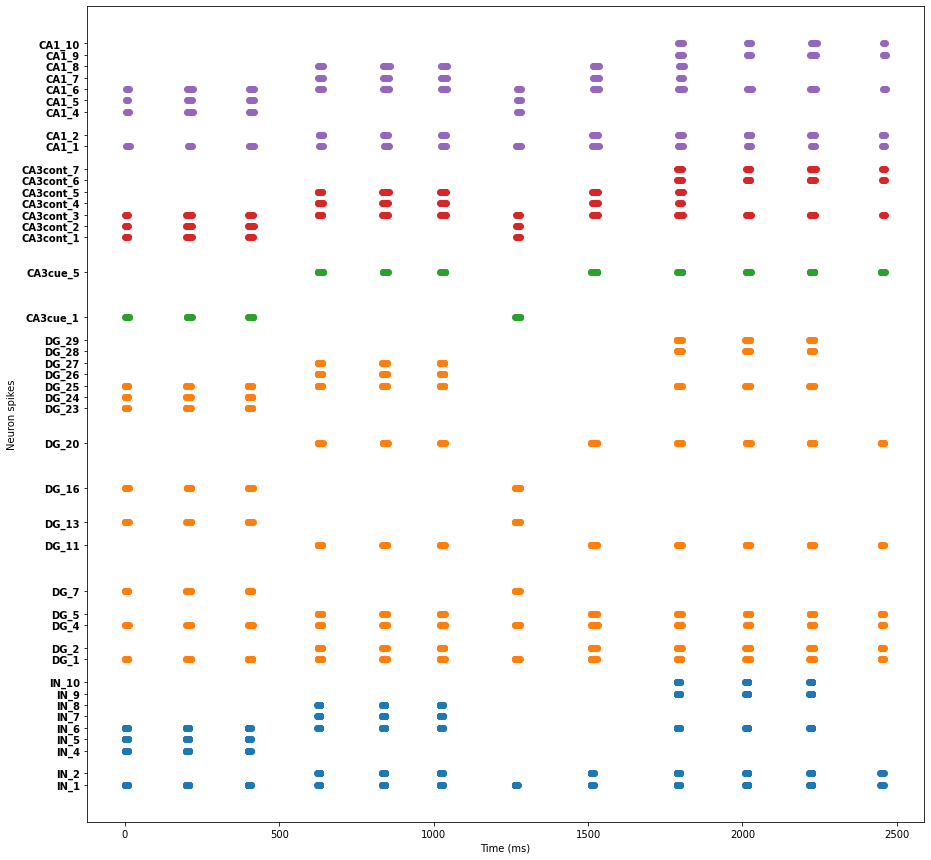

In [727]:
# Plot the spikes events in time 
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))

plt.xlabel("Time (ms)")
plt.ylabel("Neuron spikes")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
for i in range(len(events_timestamp)):
    plt.plot(events_timestamp[i], events_neuron_id_formated[i], "o")

#plt.xlim([-5, 30])
#plt.xlim([3000, 3500])
#plt.ylim([0, 40])
plt.yticks(yticks_pos, yticks, weight='bold')

plt.savefig("results/ca3_cascade_dg_opt_"+str(experiment)+".png", bbox_inches='tight')
plt.show()

In [729]:
# Close the device
close = False
if close:
    samna.device.close_device(model)